# 数据块划分

In [57]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [58]:
# 导入数据
data=np.loadtxt('../Magic.txt')
data=data[:19000,:]# 修整一下数据
X=data[:,:-1]
y=data[:,-1]
print('y: ',set(y))

y:  {1.0, 2.0}


In [59]:
data.shape

(19000, 11)

In [60]:
'''
先按HDFS数据块划分，再划分为RSP数据块
'''
K=20 # HDFS数据块个数
M=25 # RSP数据块个数
# 按顺序切分为k份
HDFS=np.array(np.split(data,K))
for i in range(HDFS.shape[0]):
    np.random.shuffle(HDFS[i])
HDFS_list=[np.split(D_k,M) for D_k in HDFS]
print('HDFS: [块数: {0} 块内元素个数: {1} 数据块维度: {2}]'.format(
    HDFS.shape[0],HDFS.shape[1],HDFS.shape[2]))

HDFS: [块数: 20 块内元素个数: 950 数据块维度: 11]


In [61]:
# 划分RSP
RSP=[[D_K[m] for D_K in HDFS_list] for m in range(M)]
for idx,RSP_ in enumerate(RSP):
    tmp_RSP=RSP_[0]
    for i in range(1,len(RSP_)):
        tmp_RSP=np.vstack((tmp_RSP,RSP_[i]))
    RSP[idx]=tmp_RSP
RSP=np.array(RSP)
print('RSP: [块数: {0} 块内元素个数: {1} 数据块维度: {2}]'.format(
    RSP.shape[0],RSP.shape[1],RSP.shape[2]))

RSP: [块数: 25 块内元素个数: 760 数据块维度: 11]


# 特征分布可视化

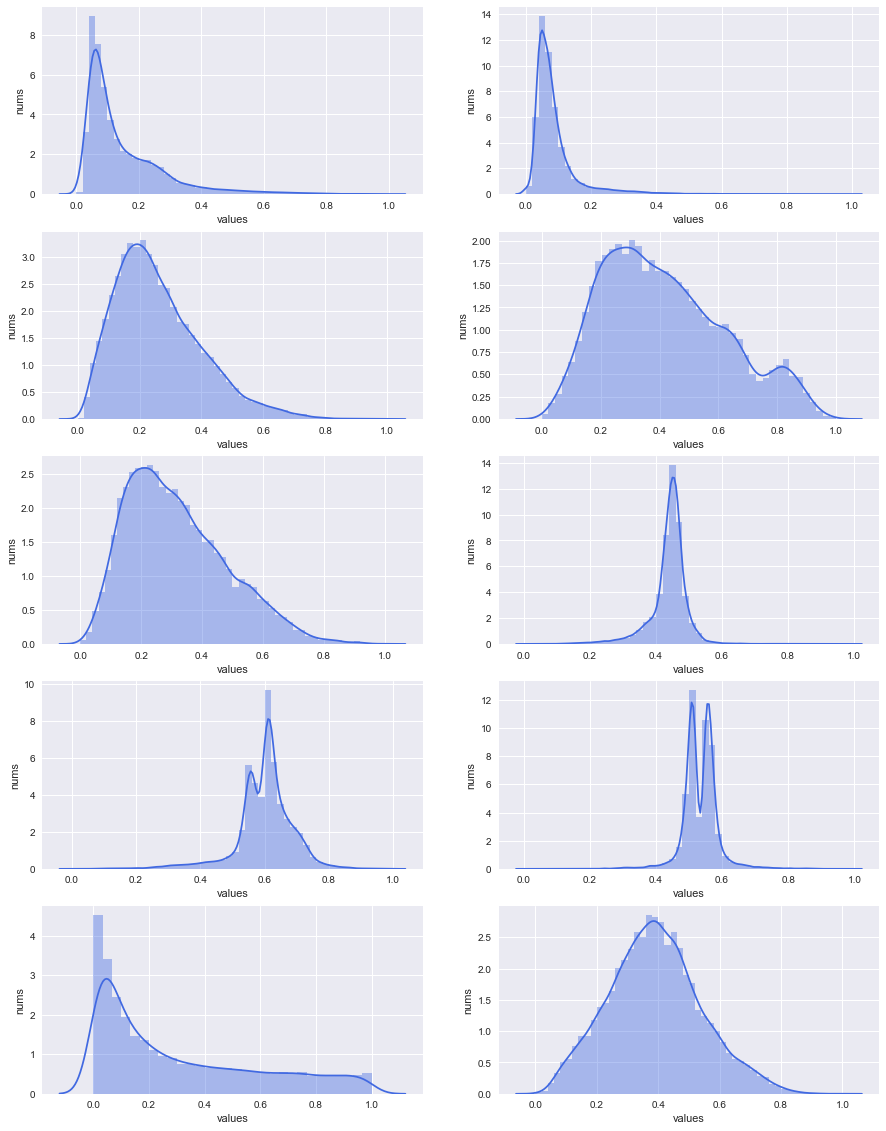

In [6]:
plt.style.use('seaborn')

fig, axes = plt.subplots(ncols=2, nrows=5,figsize=[15,20])
for i, ax in zip(range(10), axes.flat):
    # ax.set_title('fea'+str(i))
    ax.set_xlabel('values')
    ax.set_ylabel('nums')
    sns.distplot(data[:,i],
        hist=True,kde=True, ax=ax,color='royalblue')
plt.show()


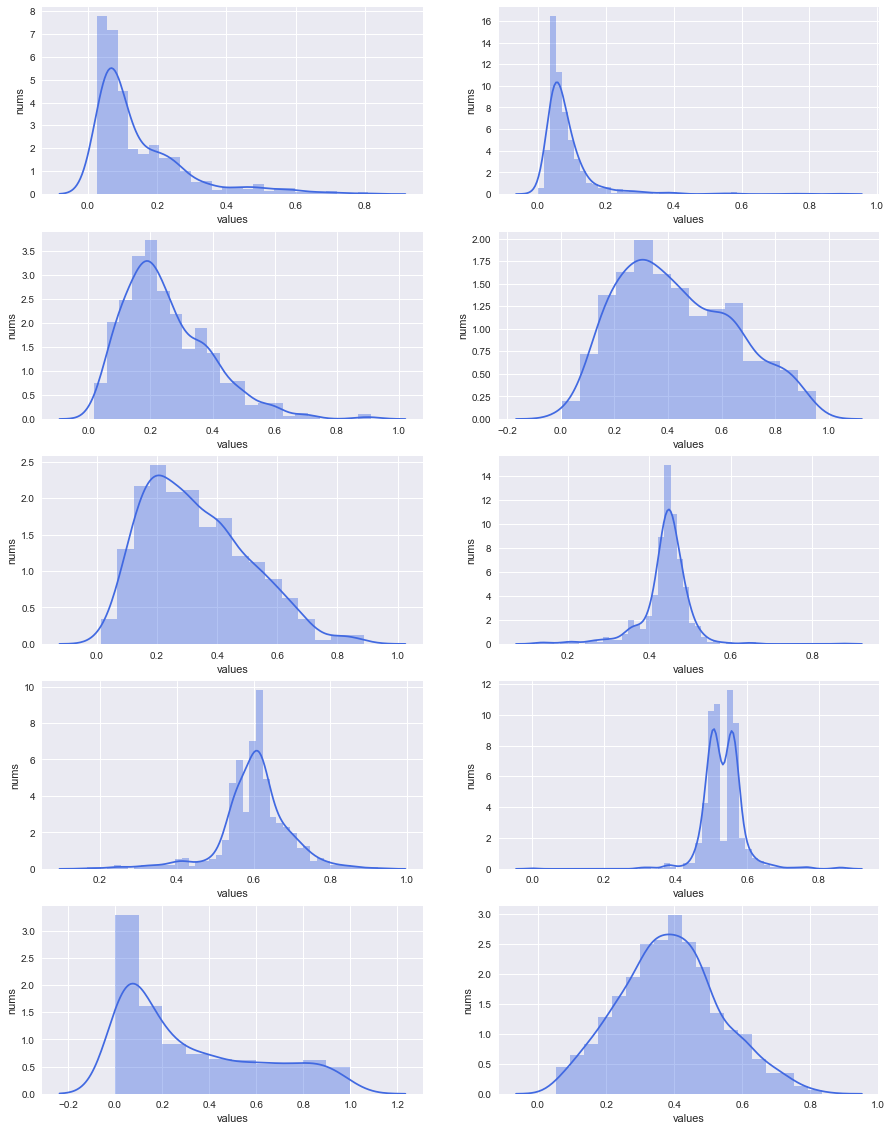

In [7]:
tmp_RSP=RSP[0,:,:-1]# RSP的某个子块
plt.style.use('seaborn')

fig, axes = plt.subplots(ncols=2, nrows=5,figsize=[15,20])
for i, ax in zip(range(10), axes.flat):
    # ax.set_title('fea'+str(i))
    ax.set_xlabel('values')
    ax.set_ylabel('nums')
    sns.distplot(tmp_RSP[:,i],
        hist=True,kde=True, ax=ax,color='royalblue')
plt.show()


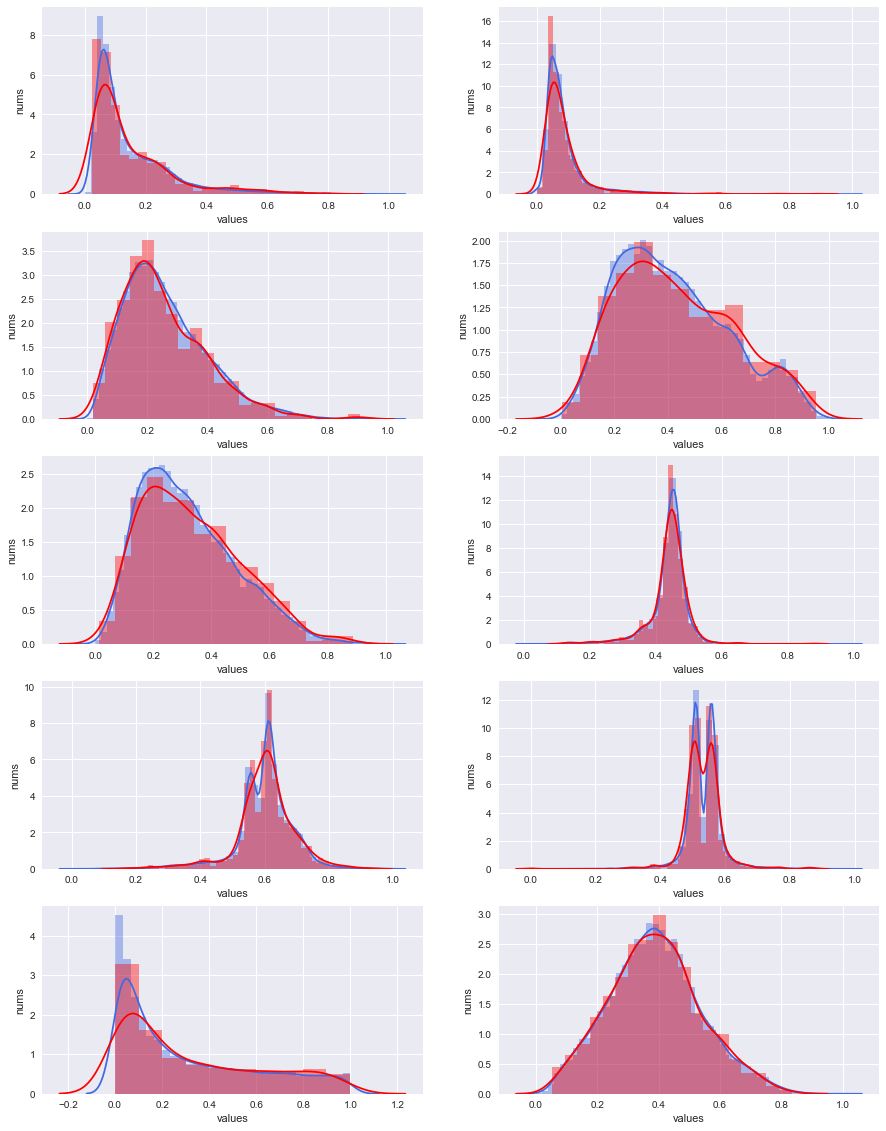

In [8]:
# 对比
plt.style.use('seaborn')
tmp_RSP=RSP[0,:,:-1]# RSP的某个子块

fig, axes = plt.subplots(ncols=2, nrows=5,figsize=[15,20])
for i, ax in zip(range(10), axes.flat):
    # ax.set_title('fea'+str(i))
    ax.set_xlabel('values')
    ax.set_ylabel('nums')
    sns.distplot(data[:,i],
        hist=True,kde=True, ax=ax,color='royalblue')
    sns.distplot(tmp_RSP[:,i],
        hist=True,kde=True, ax=ax,color='red')
plt.show()


#  数据划分完毕，准备开始特征提取
---

##  PCA

###  整体

pca.components_:  (10, 10)
pca_var_ratio:  (10,)


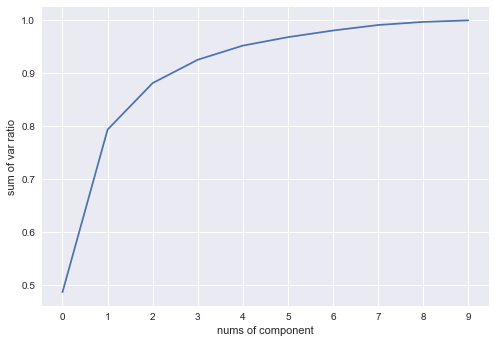

In [9]:
'''观察不同维度的方差之和'''
from sklearn.decomposition import PCA

X=data[:,:-1]
pca=PCA( )
pca.fit(X)
ratio=pca.explained_variance_ratio_ # 降维后各成分的方差占比 
print("pca.components_: ",pca.components_.shape)
print("pca_var_ratio: ",pca.explained_variance_ratio_.shape)
#绘制图形
plt.plot(range(X.shape[1]),[np.sum(ratio[:i+1]) for i in range(X.shape[1])])
plt.xlabel('nums of component')
plt.ylabel('sum of var ratio')
plt.xticks(np.arange(X.shape[1]))
plt.grid(True)
plt.show()

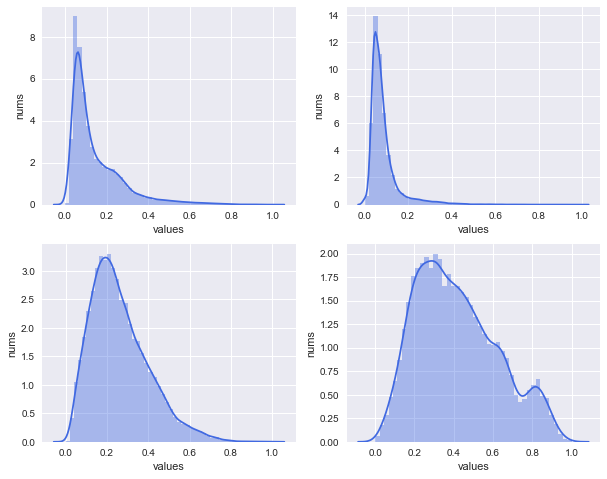

In [10]:
# 我选择降到4维
n_pca=4
pca=PCA(n_components=n_pca)
X_pca=pca.fit_transform(X)
# 绘图
plt.style.use('seaborn')
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=[10,8])
for i, ax in zip(range(4), axes.flat):
    ax.set_xlabel('values')
    ax.set_ylabel('nums')
    sns.distplot(X[:,i],
        hist=True,kde=True, ax=ax,color='royalblue')
plt.show()

### RSP

In [62]:
# 选择某块RSP
tmp_RSP=RSP[0,:,:-1]
tmp_RSP.shape

(760, 10)

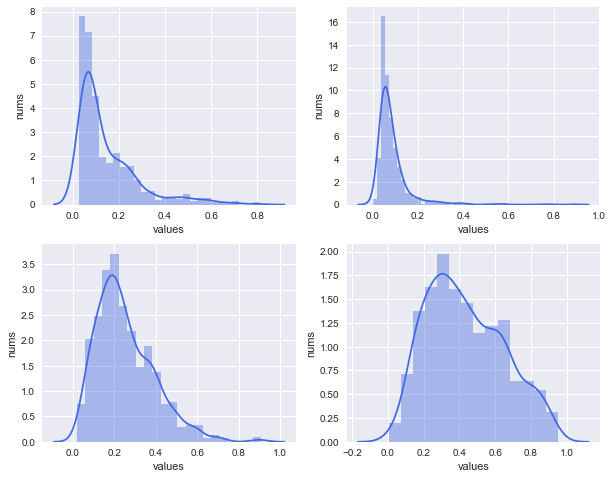

In [12]:
# 我选择降到4维
n_pca=4
pca_=PCA(n_components=n_pca)
X_pca_=pca.fit_transform(tmp_RSP)
# 绘图
plt.style.use('seaborn')
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=[10,8])
for i, ax in zip(range(4), axes.flat):
    ax.set_xlabel('values')
    ax.set_ylabel('nums')
    sns.distplot(tmp_RSP[:,i],
        hist=True,kde=True, ax=ax,color='royalblue')
plt.show()

### 对比

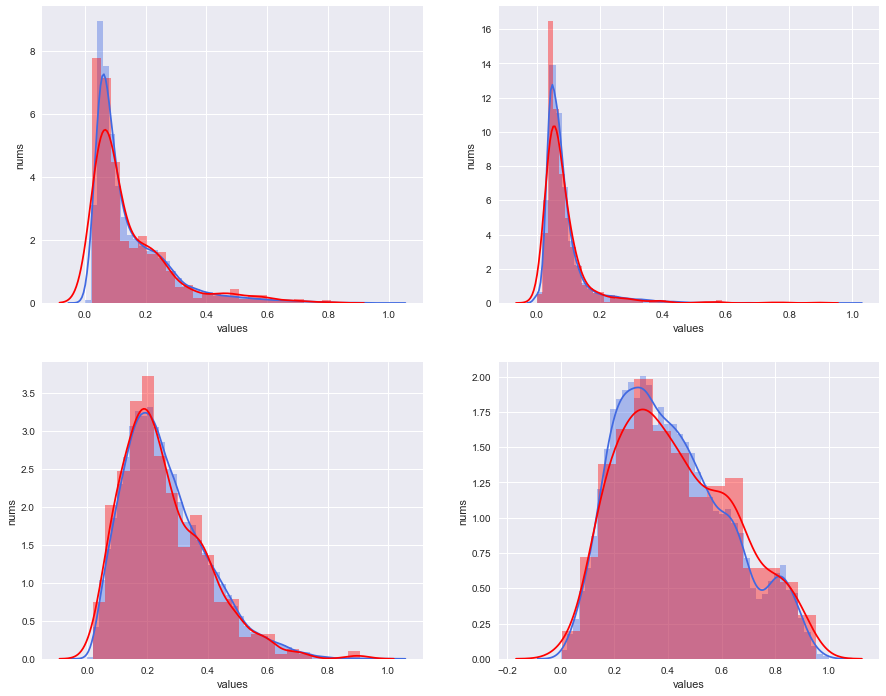

In [13]:
# 绘图
plt.style.use('seaborn')
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=[15,12])
for i, ax in zip(range(4), axes.flat):
    ax.set_xlabel('values')
    ax.set_ylabel('nums')
    sns.distplot(X[:,i],
        hist=True,kde=True, ax=ax,color='royalblue')
    sns.distplot(tmp_RSP[:,i],
        hist=True,kde=True, ax=ax,color='red')
plt.show()

## MDS
---

### 整体

In [209]:
'''由于整体的isomap降维需要非常大的内存空间，
所以此处采用整体的简单随机抽样以代替整体'''
import random
X=data[:,:-1]
sample_rate=0.2
index=random.sample(list(range(X.shape[0])),int(sample_rate*X.shape[0]))
X_sample_mds=X[index,:]

In [214]:
from sklearn.manifold import MDS
n_MDS=4
MDS=MDS(n_components=n_MDS, max_iter=100, n_init=1)
X_mds_trans=MDS.fit_transform(X_sample_mds)

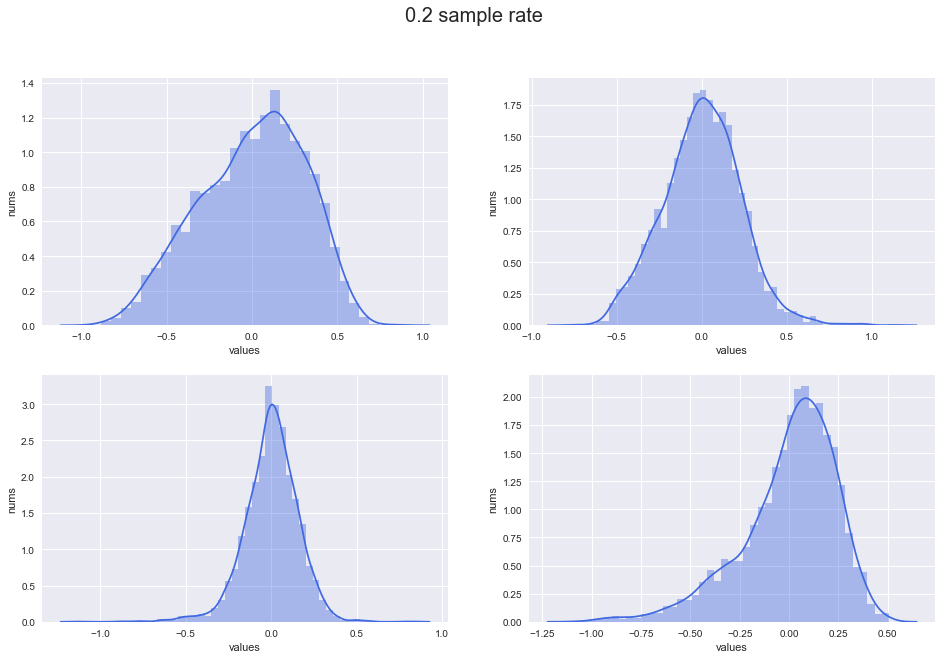

In [215]:
# 绘制特征分布图
plt.style.use('seaborn')
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=[16,10])
fig.suptitle('0.2 sample rate',size=20)
for i, ax in zip(range(4), axes.flat):
    ax.set_xlabel('values')
    ax.set_ylabel('nums')
    sns.distplot(X_mds_trans[:,i],
        hist=True,kde=True, ax=ax,color='royalblue')
plt.show()

### RSP

In [218]:
# 选择某块RSP
tmp_RSP=RSP[0,:,:-1]

n_MDS=4
from sklearn.manifold import MDS
MDS=MDS(n_components=n_MDS, max_iter=100, n_init=1)
X_mds_rsp=MDS.fit_transform(tmp_RSP)

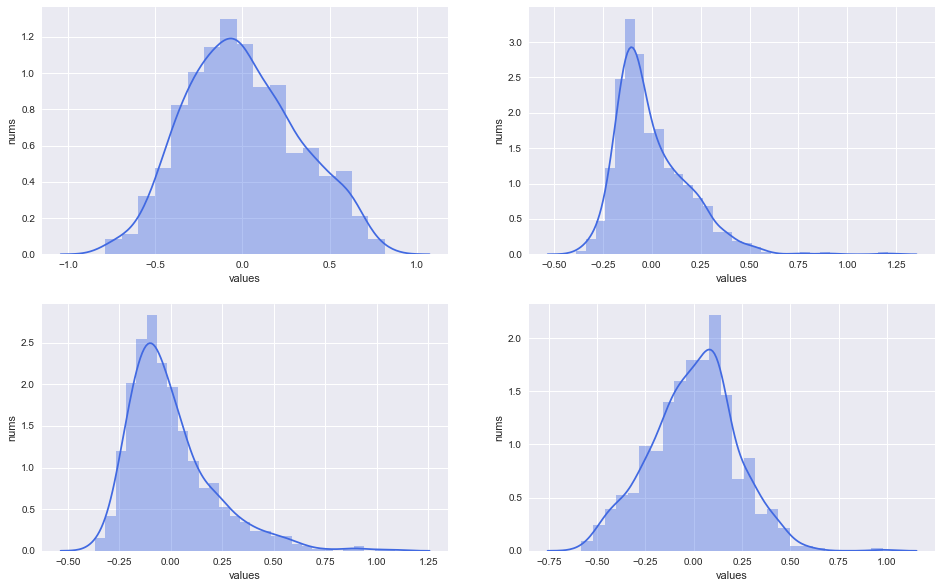

In [219]:
# 绘制特征分布图
plt.style.use('seaborn')
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=[16,10])
for i, ax in zip(range(4), axes.flat):
    ax.set_xlabel('values')
    ax.set_ylabel('nums')
    sns.distplot(X_mds_rsp[:,i],
        hist=True,kde=True, ax=ax,color='royalblue')
plt.show()

###  对比

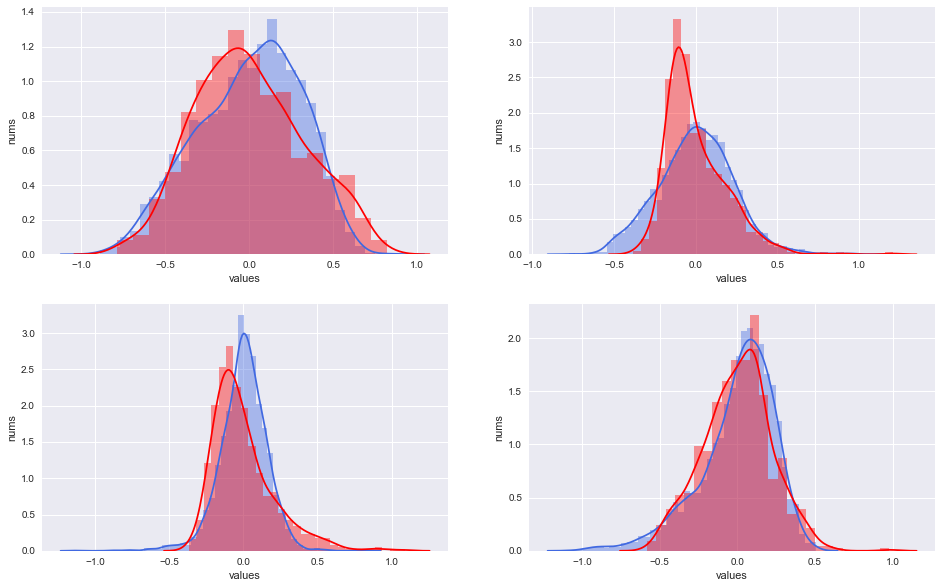

In [220]:
# 绘制特征分布图
plt.style.use('seaborn')
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=[16,10])
for i, ax in zip(range(4), axes.flat):
    ax.set_xlabel('values')
    ax.set_ylabel('nums')
    sns.distplot(X_mds_trans[:,i],
        hist=True,kde=True, ax=ax,color='royalblue')
    sns.distplot(X_mds_rsp[:,i],
        hist=True,kde=True, ax=ax,color='red')
plt.show()

##  LLE
---

In [72]:
from functools import partial
from sklearn.manifold import LocallyLinearEmbedding
n_neighbors = 10
n_components = 4
# 设置流形学习的方法
LLE = partial(
    LocallyLinearEmbedding,
    n_neighbors=n_neighbors,
    n_components=n_components,
    eigen_solver="auto",
)

###  整体

In [73]:
X=data[:,:-1]
LLE_standard=LLE(method="standard")
LLE_standard.fit(X)

LocallyLinearEmbedding(n_components=4, n_neighbors=10)

In [107]:
# 保存模型
import joblib
joblib.dump(LLE_standard, "LLE_standard_4.m")

['LLE_standard_4.m']

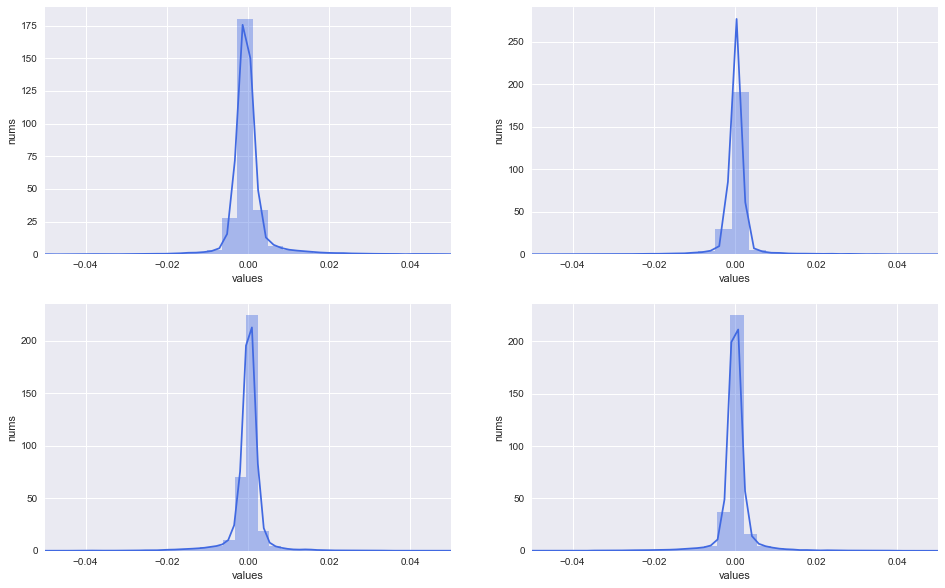

In [110]:
# 绘制特征分布图
X_LLE_std=LLE_standard.transform(X)
# 绘图
plt.style.use('seaborn')
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=[16,10])
for i, ax in zip(range(4), axes.flat):
    ax.set_xlabel('values')
    ax.set_ylabel('nums')
    ax.set_xlim([-0.05,0.05])
    sns.distplot(X_LLE_std[:,i],
        hist=True,bins=100,kde=True, ax=ax,color='royalblue')
plt.show()

###  RSP

In [111]:
# 选择某块RSP
tmp_RSP=RSP[0,:,:-1]
tmp_RSP.shape

(760, 10)

In [112]:
LLE_std_=LLE(method="standard")
LLE_std_.fit(tmp_RSP)

LocallyLinearEmbedding(n_components=4, n_neighbors=10)

In [113]:
# 保存模型
import joblib
joblib.dump(LLE_std_, "LLE_standard_RSP_4.m")

['LLE_standard_RSP_4.m']

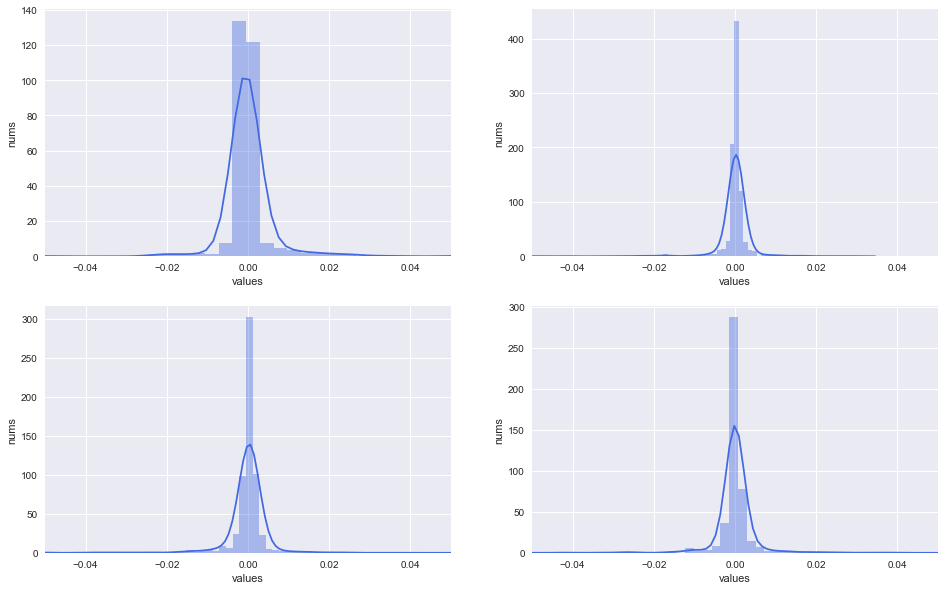

In [114]:
# 绘制特征分布图
X_LLE_std_RSP=LLE_standard.transform(tmp_RSP)
# 绘图
plt.style.use('seaborn')
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=[16,10])
for i, ax in zip(range(4), axes.flat):
    ax.set_xlabel('values')
    ax.set_ylabel('nums')
    ax.set_xlim([-0.05,0.05])
    sns.distplot(X_LLE_std_RSP[:,i],
        hist=True,bins=100,kde=True, ax=ax,color='royalblue')
plt.show()

### 对比

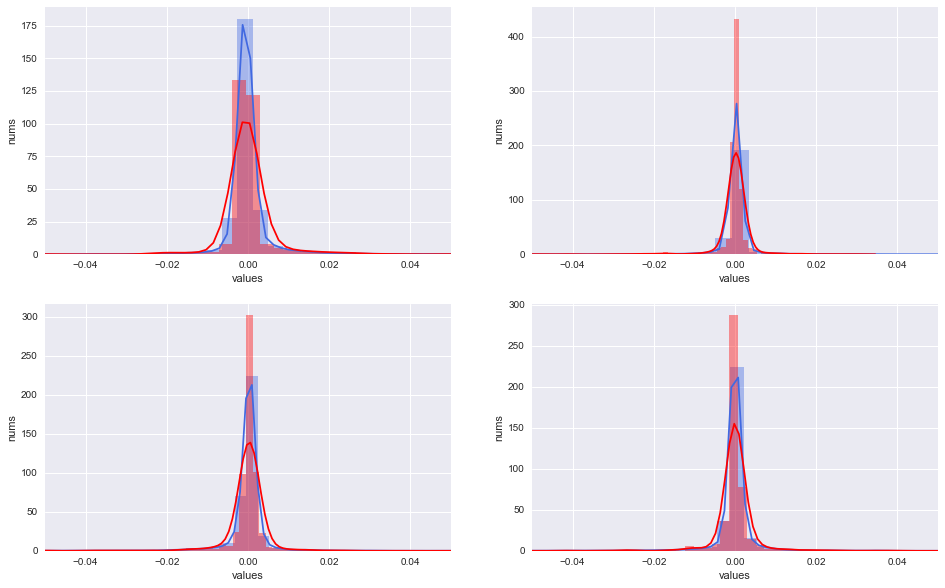

In [115]:
# 绘制特征分布图
X_LLE_std_RSP=LLE_standard.transform(tmp_RSP)
# 绘图
plt.style.use('seaborn')
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=[16,10])
for i, ax in zip(range(4), axes.flat):
    ax.set_xlabel('values')
    ax.set_ylabel('nums')
    ax.set_xlim([-0.05,0.05])
    sns.distplot(X_LLE_std[:,i],
        hist=True,bins=100,kde=True, ax=ax,color='royalblue')
    sns.distplot(X_LLE_std_RSP[:,i],
        hist=True,bins=100,kde=True, ax=ax,color='red')
plt.show()

降维之后少了很多噪声，所以分布较为扁平

##  LDA
---

### 整体

In [221]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=1)
X=data[:,:-1]
y=data[:,-1]
lda.fit(X,y)

LinearDiscriminantAnalysis(n_components=1)

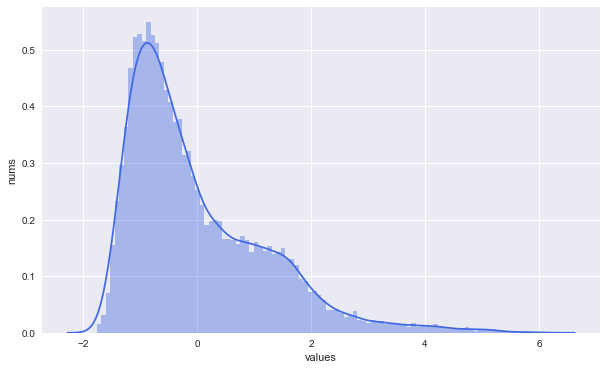

In [222]:
# 绘制特征分布图
X_lda = lda.transform(X)
# 绘图
plt.style.use('seaborn')
plt.figure(figsize=[10,6])
plt.xlabel('values')
plt.ylabel('nums')
sns.distplot(X_lda[:,0],
    hist=True,bins=100,kde=True,color='royalblue')
plt.show()

### RSP

In [223]:
# 选择某块RSP
X_lda_RSP=RSP[0,:,:-1]
y_lda_RSP=RSP[0,:,-1]
X_lda_RSP.shape

(760, 10)

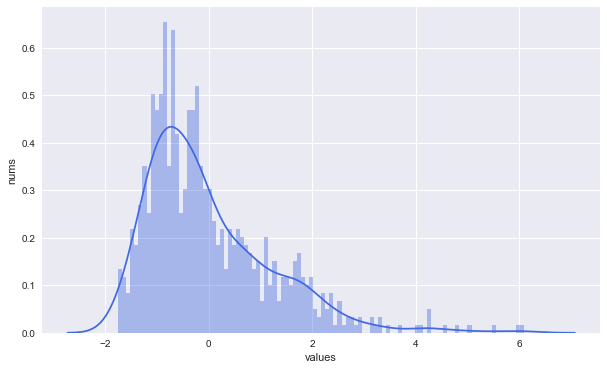

In [231]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_lda_RSP,y_lda_RSP)

# 绘制特征分布图
X_lda_trans = lda.transform(X_lda_RSP)
# 绘图
plt.style.use('seaborn')
plt.figure(figsize=[10,6])
plt.xlabel('values')
plt.ylabel('nums')
sns.distplot(X_lda_trans[:,0],
    hist=True,bins=100,kde=True,color='royalblue')
plt.show()

###  对比

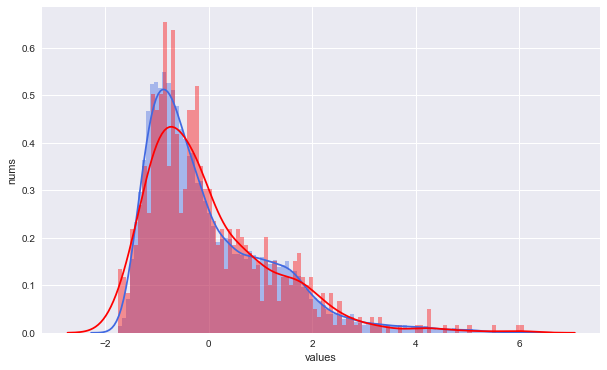

In [232]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_lda_RSP,y_lda_RSP)

# 绘制特征分布图
X_lda_trans = lda.transform(X_lda_RSP)
# 绘图
plt.style.use('seaborn')
plt.figure(figsize=[10,6])
plt.xlabel('values')
plt.ylabel('nums')
sns.distplot(X_lda[:,0],
    hist=True,bins=100,kde=True,color='royalblue')
sns.distplot(X_lda_trans[:,0],
    hist=True,bins=100,kde=True,color='red')
plt.show()

## Isomap
---

In [116]:
from sklearn.manifold import Isomap
n_neighbors=5
n_components=4
Iso=Isomap(n_neighbors=n_neighbors, n_components=n_components)

### 整体

In [140]:
X.shape

(19000, 10)

In [201]:
'''由于整体的isomap降维需要非常大的内存空间，
所以此处采用整体的简单随机抽样以代替整体'''
import random
X=data[:,:-1]
sample_rate=0.7
index=random.sample(list(range(X.shape[0])),int(sample_rate*X.shape[0]))
X_sample_isomap=X[index,:]

In [202]:
X_sample_isomap.shape

(13300, 10)

In [203]:
from sklearn.manifold import Isomap
n_neighbors=5
n_components=4
Iso=Isomap(n_neighbors=n_neighbors, n_components=n_components)
X_iso_trans=Iso.fit_transform(X_sample_isomap)

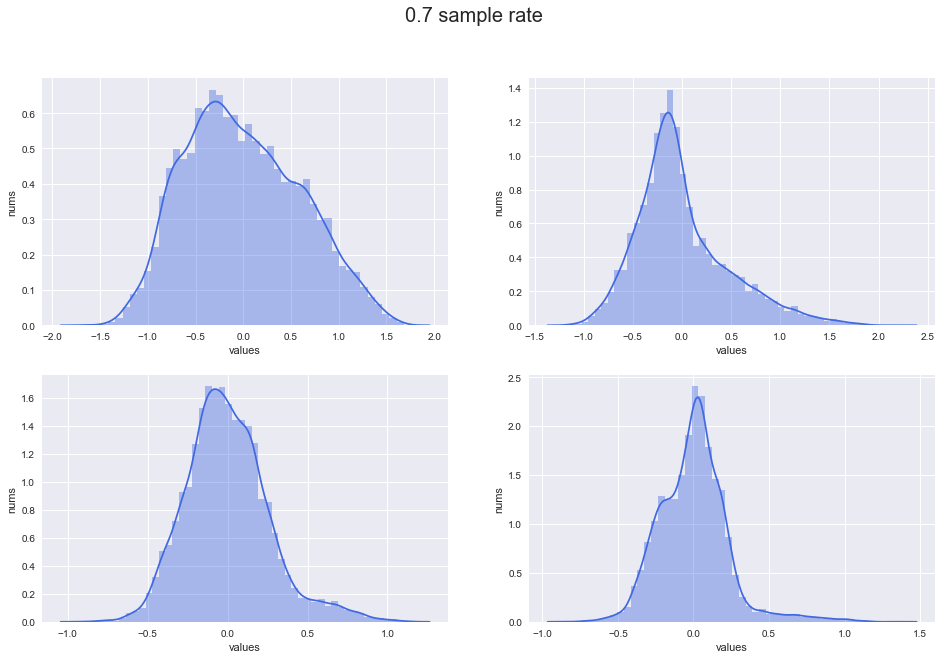

In [204]:
# 绘制特征分布图
plt.style.use('seaborn')
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=[16,10])
fig.suptitle('0.7 sample rate',size=20)
for i, ax in zip(range(4), axes.flat):
    ax.set_xlabel('values')
    ax.set_ylabel('nums')
    sns.distplot(X_iso_trans[:,i],
        hist=True,kde=True, ax=ax,color='royalblue')
plt.show()

## RSP

In [118]:
# 选择某块RSP
tmp_RSP=RSP[0,:,:-1]
tmp_RSP.shape

(760, 10)

In [122]:
n_neighbors = 10
n_components = 4
Iso_RSP=Isomap(n_neighbors=n_neighbors, n_components=n_components)
X_iso_RSP=Iso_RSP.fit_transform(tmp_RSP)

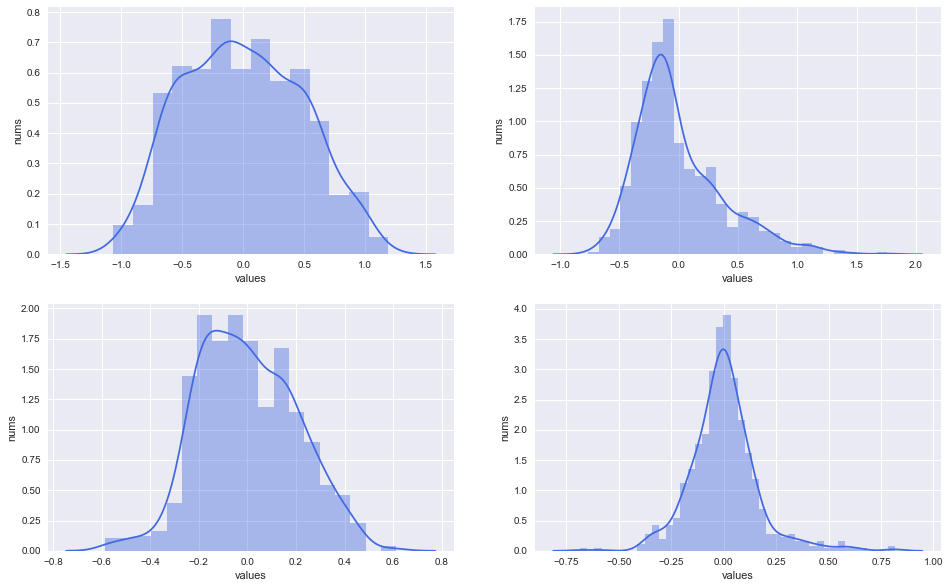

In [124]:
# 绘制特征分布图
plt.style.use('seaborn')
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=[16,10])
for i, ax in zip(range(4), axes.flat):
    ax.set_xlabel('values')
    ax.set_ylabel('nums')
    sns.distplot(X_iso_RSP[:,i],
        hist=True,kde=True, ax=ax,color='royalblue')
plt.show()

### 对比

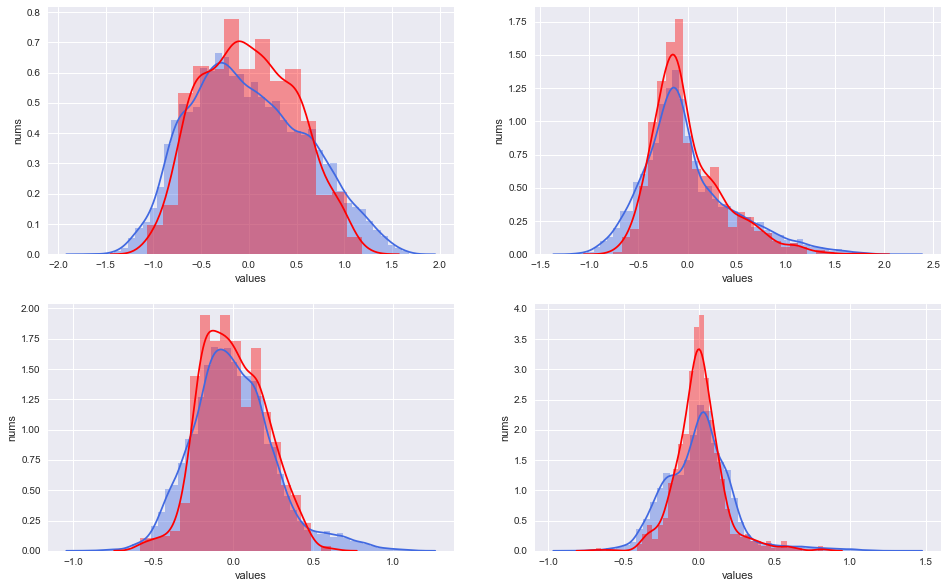

In [205]:
# 绘制特征分布图
plt.style.use('seaborn')
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=[16,10])
for i, ax in zip(range(4), axes.flat):
    ax.set_xlabel('values')
    ax.set_ylabel('nums')
    sns.distplot(X_iso_trans[:,i],
        hist=True,kde=True, ax=ax,color='royalblue')
    sns.distplot(X_iso_RSP[:,i],
        hist=True,kde=True, ax=ax,color='red')
plt.show()